The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# Dropout
:label:`sec_dropout`

在 :numref:`sec_weight_decay` 中，我们介绍了通过惩罚权重的$L_2$范数来正则化统计模型的经典方法。在概率角度看，我们可以通过以下论证来证明这一技术的合理性：我们已经假设了一个先验，即权重的值取自均值为0的高斯分布。更直观的是，我们可能会说，我们鼓励模型将其权重分散到许多特征中，而不是过于依赖少数潜在的虚假关联。

## 重新审视过拟合

当面对更多的特征而样本不足时，线性模型往往会过度拟合。当给出更多样本而不是特征，我们通常可以指望线性模型不会过拟合。不幸的是，线性模型泛化的可靠性是有代价的。简单地说，线性模型没有考虑到特征之间的交互作用。对于每个特征，线性模型必须指定正的或负的权重，而忽略上下文。

在传统说法中，泛化性和灵活性之间的这种基本权衡被描述为*偏差-方差权衡*（bias-variance tradeoff）。线性模型有很高的偏差：它们只能表示一小类函数。然而，这些模型的方差很低：它们在不同的随机数据样本上给出了相似的结果。

深度神经网络位于偏差-方差谱的另一端。与线性模型不同，神经网络并不局限于单独查看每个特征。它们可以学习特征之间的交互。例如，它们可能推断“尼日利亚”和“西联汇款”一起出现在电子邮件中表示垃圾邮件，但单独出现则不表示垃圾邮件。

即使我们有比特征多得多的样本，深度神经网络也有可能过拟合。2017年，一组研究人员通过在随机标记的图像上训练深度网络。这展示了神经网络的极大灵活性。因为没有任何真实的模式将输入和输出联系起来，但他们发现，通过随机梯度下降优化的神经网络可以完美地标记训练集中的每一幅图像。想一想这意味着什么。如果标签是随机均匀分配的，并且有10个类别，那么在保留数据上没有分类器会取得高于10%的准确率。这里的泛化差距高达90%。如果我们的模型具有这么强的表达能力，以至于它们可以如此严重地过拟合，那么我们指望在什么时候它们不会过拟合呢？

深度网络有着令人费解的泛化性质，而这种泛化性质的数学基础仍然是悬而未决的研究问题，我们鼓励面向理论的读者更深入地研究这个主题。目前，我们转向对实际工具的探究，这些工具倾向于经验上改进深层网络的泛化性。

## 扰动的鲁棒性

让我们简单地思考一下我们对一个好的预测模型的期待。我们期待它能在看不见的数据上有很好的表现。经典泛化理论认为，为了缩小训练和测试性能之间的差距，我们应该以简单的模型为目标。简单性以较小维度的形式出现。我们在 :numref:`sec_model_selection` 讨论线性模型的单项式函数时探讨了这一点。此外，正如我们在 :numref:`sec_weight_decay` 中讨论权重衰减（$L_2$正则化）时看到的那样，参数的范数也代表了一种有用的简单性度量。简单性的另一个有用角度是平滑性，即函数不应该对其输入的微小变化敏感。例如，当我们对图像进行分类时，我们预计向像素添加一些随机噪声应该是基本无影响的。

1995年，克里斯托弗·毕晓普证明了具有输入噪声的训练等价于Tikhonov正则化 :cite:`Bishop.1995` ，从而将这一观点正式化。这项工作在要求函数光滑(因而简单)和要求它对输入中的扰动具有适应性之间有了明确的数学联系。

然后，在2014年，斯里瓦斯塔瓦等人 :cite:`Srivastava.Hinton.Krizhevsky.ea.2014` 还就如何将毕晓普的想法应用于网络的内部层提出了一个聪明的想法。在训练过程中，他们建议在计算后续层之前向网络的每一层注入噪声。他们意识到，当训练一个有多层的深层网络时，注入噪声只会在输入-输出映射上增强平滑性。

他们的想法被称为*暂退法*（dropout），dropout在正向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的标准技术。这种方法之所以被称为 *dropout* ，因为我们从表面上看是在训练过程中丢弃（drop out）一些神经元。
在整个训练过程的每一次迭代中，dropout包括在计算下一层之前将当前层中的一些节点置零。

需要说明的是，我们将自己的叙述与毕晓普联系起来。关于dropout的原始论文出人意料地通过一个有性繁殖类比提供了直觉。作者认为，神经网络过拟合的特征是每一层都依赖于前一层激活值的特定模式，称这种情况为“共适应性”。他们声称，dropout会破坏共适应性，就像有性生殖会破坏共适应的基因一样。

那么关键的挑战就是如何注入这种噪声。一种想法是以一种*无偏*的方式注入噪声。这样在固定住其他层时，每一层的期望值等于没有噪音时的值。

在毕晓普的工作中，他将高斯噪声添加到线性模型的输入中。在每次训练迭代中，他将从均值为零的分布$\epsilon \sim \mathcal{N}(0,\sigma^2)$采样噪声添加到输入$\mathbf{x}$，从而产生扰动点$\mathbf{x}' = \mathbf{x} + \epsilon$。预期是$E[\mathbf{x}'] = \mathbf{x}$。

在标准dropout正则化中，通过按保留（未丢弃）的节点的分数进行归一化来消除每一层的偏差。换言之，每个中间激活值$h$以*丢弃概率*$p$由随机变量$h'$替换，如下所示：

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ 概率为 } p \\
    \frac{h}{1-p} & \text{ 其他情况}
\end{cases}
\end{aligned}
$$

根据设计，期望值保持不变，即$E[h'] = h$。

## 实践中的dropout

回想一下 :numref:`fig_mlp` 中带有一个隐藏层和5个隐藏单元的多层感知机。当我们将dropout应用到隐藏层，以$p$的概率将隐藏单元置为零时，结果可以看作是一个只包含原始神经元子集的网络。在 :numref:`fig_dropout2` 中，删除了$h_2$和$h_5$。因此，输出的计算不再依赖于$h_2$或$h_5$，并且它们各自的梯度在执行反向传播时也会消失。这样，输出层的计算不能过度依赖于$h_1, \ldots, h_5$的任何一个元素。

![dropout前后的多层感知机。](http://d2l.ai/_images/dropout2.svg)
:label:`fig_dropout2`

通常，我们在测试时禁用dropout。给定一个训练好的模型和一个新的样本，我们不会丢弃任何节点，因此不需要标准化。然而，也有一些例外：一些研究人员使用测试时的dropout作为估计神经网络预测的“不确定性”的启发式方法：如果预测在许多不同的dropout掩码上都是一致的，那么我们可以说网络更有自信心。

## 从零开始实现

要实现单层的dropout函数，我们必须从伯努利（二元）随机变量中提取与我们的层的维度一样多的样本，其中随机变量以概率$1-p$取值$1$（保持），以概率$p$取值$0$（丢弃）。实现这一点的一种简单方式是首先从均匀分布$U[0, 1]$中抽取样本。那么我们可以保留那些对应样本大于$p$的节点，把剩下的丢弃。

在下面的代码中，(**我们实现 `dropout_layer` 函数，该函数以`dropout`的概率丢弃张量输入`X`中的元素**)，如上所述重新缩放剩余部分：将剩余部分除以`1.0-dropout`。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃。
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留。
    if dropout == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask * X / (1.0 - dropout)

我们可以通过几个例子来[**测试`dropout_layer`函数**]。在下面的代码行中，我们将输入`X`通过dropout操作，丢弃概率分别为0、0.5和1。


In [2]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  6.,  0.,  0.,  0., 14.],
        [16.,  0., 20., 22., 24., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### 定义模型参数

同样，我们使用 :numref:`sec_fashion_mnist` 中引入的Fashion-MNIST数据集。我们[**定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元**]。


In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### 定义模型

下面的模型将dropout应用于每个隐藏层的输出（在激活函数之后）。我们可以分别为每一层设置丢弃概率。
一种常见的技巧是在靠近输入层的地方设置较低的丢弃概率。
下面，我们将第一个和第二个隐藏层的丢弃概率分别设置为0.2和0.5。我们确保dropout只在训练期间有效。


In [4]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### [**训练和测试**]

这类似于前面描述的多层感知机训练和测试。


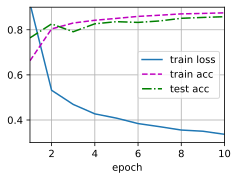

In [5]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## [**简洁实现**]

对于高级API，我们所需要做的就是在每个全连接层之后添加一个`Dropout`层，将丢弃概率作为唯一的参数传递给它的构造函数。在训练过程中，`Dropout`层将根据指定的丢弃概率随机丢弃上一层的输出（相当于下一层的输入）。当不处于训练模式时，`Dropout`层仅在测试时传递数据。


In [6]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

接下来，我们[**对模型进行训练和测试**]。


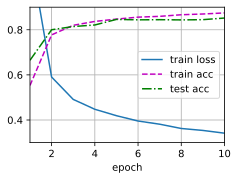

In [7]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 小结

* 除了控制权重向量的维数和大小之外，dropout也是避免过拟合的另一种工具。它们通常是联合使用的。
* dropout将激活值$h$替换为具有期望值$h$的随机变量。
* dropout仅在训练期间使用。

## 练习

1. 如果更改第一层和第二层的dropout概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述你的结果，并总结定性的结论。
1. 增加迭代周期数，并将使用dropout和不使用dropout时获得的结果进行比较。
1. 当应用或不应用dropout时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的。
1. 为什么在测试时通常不使用dropout？
1. 以本节中的模型为例，比较使用dropout和权重衰减的效果。如果同时使用dropout和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？
1. 如果我们将dropout应用到权重矩阵的各个权重，而不是激活值，会发生什么？
1. 发明另一种用于在每一层注入随机噪声的技术，该技术不同于标准的dropout技术。你能否开发一种在Fashion-MNIST数据集(对于固定结构)上性能优于dropout的方法？


[Discussions](https://discuss.d2l.ai/t/1813)
